[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1iRf6_ZXi2yPemZSJr2bMi4qQ7PM851ok?usp=sharing)

# Introduction - Fireworks x LangGraph

In this notebook, we demonstrate how to use the Fireworks function-calling model as a router across multiple models with specialized capabilities. Function-calling models have seen a rapid rise in usage due to their ability to easily utilize external tools. One such powerful tool is other LLMs. We have a variety of specialized OSS LLMs for [coding](https://www.deepseek.com/), [chatting in certain languages](https://github.com/QwenLM/Qwen), or just plain [HF Assistants](https://huggingface.co/chat/assistants).

The function-calling model allows us to:
1. Analyze the user query for intent.
2. Find the best model to answer the request, which could even be the function-calling model itself!
3. Construct the right query for the chosen LLM.
4. Profit!

This notebook is a sister notebook to LangChain, though we will use the newer and more controllable[LangGraph](https://www.langchain.com/langgraph) framework to construct an agent graph capable of chit-chatting and solving math equations using a calculator tool.

This agent chain will utilize [custom-defined tools](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/) capable of executing a math query using an LLM. The main routing LLM will be the Fireworks function-calling model.



---



In [13]:
!pip3 install langgraph langchain-fireworks


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


## Setup Dependencies

To accomplish the task in this notebook, we need to import some dependencies from LangChain to interface with the model. Specifically, we will use the [ChatFireworks](https://python.langchain.com/v0.2/docs/integrations/chat/fireworks/) implementation.

For solving our math equations, we will use the recently released [Firefunction V2](https://fireworks.ai/blog/firefunction-v2-launch-post) and interface with it using the [Fireworks Inference Service](https://fireworks.ai/models).

To use the Fireworks AI function-calling model, you must first obtain Fireworks API keys. If you don't already have one, you can get one by following the instructions [here](https://readme.fireworks.ai/docs/quickstart). When prompted below paste in your `FIREWORKS_API_KEY`.

**NOTE:** It's important to set the temperature to 0.0 for the function-calling model because we want reliable behavior in routing.


In [14]:
import getpass
import os

from langchain_fireworks import ChatFireworks

# Replace 'YOUR_API_KEY_HERE' with your actual API key
FIREWORKS_API_KEY = "<YOUR_FIREWORKS_API_KEY>"

# Initialize a Fireworks chat model
llm = ChatFireworks(
  model="accounts/fireworks/models/firefunction-v2",
  temperature=0.0,
  max_tokens=256
  )

## Base LangGraph

In [15]:
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import AnyMessage, add_messages

# This is the default state  same as "MessageState" TypedDict but allows us accessibility to
# custom keys to our state like user's details
class GraphsState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # user_id: int

graph = StateGraph(GraphsState)

def _call_model(state: GraphsState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

graph.add_edge(START, "modelNode")
graph.add_node("modelNode", _call_model)
graph.add_edge("modelNode", END)

graph_runnable = graph.compile()

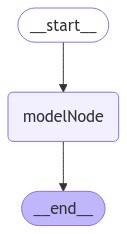

In [16]:
#We can visualize it using Mermaid
from IPython.display import Image, display

try:
    display(Image(graph_runnable.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
# simple Fireworks x LangGraph implementation
resp = graph_runnable.invoke({"messages": HumanMessage("What is your name?")})
resp["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm an AI assistant, and I don't have a personal name. I'm here to help you with any questions or tasks you may have.


## Custom Tools

To seamlessly use the function-calling ability of the models, we can utilize the [Tool Node](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/) functionality built into LangGraph. This allows the model to select the appropriate tool based on the given options.

For this notebook, we will construct an `area_of_circle` function, which will use an LLM to calculate and return the area of a circle given a radius `r`.


In [18]:
import math

from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

@tool
def get_weather(location: str):
    """Call to get the fake current weather"""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

@tool
def area_of_circle(r: float):
    """Call to get the area of a circle in units squared"""
    return math.pi * r * r


tools = [get_weather, area_of_circle]
tool_node = ToolNode(tools)

model_with_tools = llm.bind_tools(tools)

now let's adjust the graph to include the ToolNode

In [19]:
from typing import Literal
from langgraph.graph import START, END, StateGraph, MessagesState

#note for clarity, I am treating this cell as if `Base LangGraph` was not instantiated, but `Setup Dep` was.

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def tool_handler(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

workflow = StateGraph(MessagesState)

workflow.add_edge(START, "modelNode")
workflow.add_node("modelNode", call_model)
workflow.add_conditional_edges(
    "modelNode",
    tool_handler,
)
workflow.add_node("tools", tool_node)
workflow.add_edge("tools", "modelNode")

app = workflow.compile()

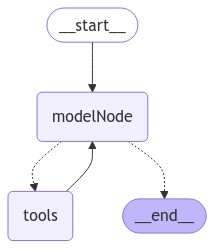

In [20]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Test Chit Chat Ability

As we outlined in the beginning, the model should be able to both chit-chat, route queries to external tools when necessary or answer from internal knowledge.

Let's first start with a question that can be answered from internal knowledge.

In [21]:
from langchain_core.messages import HumanMessage
app.invoke({"messages": HumanMessage("Who was the first President of the USA?")})["messages"][-1].pretty_print()

================================== Ai Message ==================================

George Washington was the first President of the United States.


## Test Area of Circle and Weather in SF

Now let's test it's ability to detect a area of circle or weather questions & route the query accordingly.

In [22]:
from langchain_core.messages import HumanMessage
while True:
  user = input("User (q/Q to quit): ")
  if user in {"q", "Q"}:
    print("AI: Byebye")
    break
  for output in app.stream({"messages": HumanMessage(user)}, stream_mode="updates"):
    last_message = next(iter(output.values()))['messages'][-1]
    last_message.pretty_print()

================================== Ai Message ==================================

I'm here to help! What would you like to know?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_Vee0KBC1mhiypoeH6sWoyUYg)
 Call ID: call_Vee0KBC1mhiypoeH6sWoyUYg
  Args:
    location: SF
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in Berkeley in the spring can be quite pleasant, with average highs in the mid-60s to low 70s Fahrenheit (18-22°C). However, it can still be a bit chilly in the mornings and evenings, so it's a good idea to pack layers.

For a wedding, you'll likely want to dress up a bit, so consider packing:

* A dress or suit in a lightweight, breat

KeyboardInterrupt: Interrupted by user

# Conclusion

The fireworks function calling model can route request to external tools or internal knowledge appropriately - thus helping developers build co-operative agents.